In [1]:
import torch
import logomaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import sys
sys.path.append('..')
from modify.utils import *
from modify.optimization import MODIFYOptimization

import warnings
warnings.filterwarnings('ignore')

# Introduction

This jupyter notebook provides the reproduction of starting library design for the GB1 protein at residue 39, 40, 41, and 54. There are three major computation steps:
1. Zero-shot protein fitness prediction (ESM-1v, ESM-2, EVmutation, EVE, and MSA Transformer). Due to the large computational cost, please refer to `README.md` and `notebooks/zero.ipynb` for detailed implementation.
2. Library design with residue-level diversity control, including the **default** and **informed** setting of MODIFY.
3. Structure-based filtering (FoldX and ESMFold). Due to the large computational cost, please refer to `README.md` and `notebooks/structure.ipynb` for detailed implementation.

# Implementation

## 1. MODIFY default without masked AAs

To reproduce, first follow the below instructions to run `scripts/run_modify.py`.
```
python scripts/run_modify.py \
        --protein GB1 \
        --offset 1 \
        --positions 39,40,41,54 \
        --fitness_col modify_fitness \
        --parallel \
        --num_proc 60 \
        --seed 29
```

The below codes are for data analyses and visualization.

In [2]:
protein='GB1'
offset = 1
positions=[39,40,41,54]
masked_AAs = []
fitness_col='modify_fitness'
seed = 29

In [3]:
modify = MODIFYOptimization(protein, offset, positions, masked_AAs, fitness_col, seed, path='../')

Sequence data for GB1 loaded...
starting sequence: MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
target residues: V39,D40,G41,V54
Mask loaded...
Mask shape: torch.Size([4, 20])
Mask: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]])
No masked AAs
Fitness data loaded...
[ 1.42466093  0.37217079  0.29993214 ...  1.26230785 -0.4562936
 -0.26499015]


In [4]:
"""
select library with the maximum fitness * diversity
"""

# load libraries as characterized by lambda
df = pd.read_csv(f'../results/GB1/default_pareto_{seed}.csv', index_col=0)
df['area'] = df.entropy * df['mean fitness']
df

,lambda,entropy,mean fitness,area
0,0.01,0.077747,5.046073,0.392316
1,0.02,0.095654,5.043222,0.482405
2,0.03,0.120142,5.039727,0.605481
3,0.04,0.146271,5.035944,0.736610
4,0.05,0.200428,5.030180,1.008191
...,...,...,...,...
195,1.96,2.968106,0.411129,1.220274
196,1.97,2.968390,0.408887,1.213735
197,1.98,2.968679,0.406597,1.207057
198,1.99,2.969004,0.404012,1.199512


In [5]:
# find the library with the highest area
entropy_opt, mean_fitness_opt = df.loc[[df.area.argmax()]][['entropy', 'mean fitness']].values.tolist()[0]
lam = df.loc[[df.area.argmax()]]['lambda'].values[0]
lam_default = round(lam,2)
lam_default, entropy_opt, mean_fitness_opt

(0.42, 1.9245448112487795, 3.1490663135229005)

In [6]:
plt.rcParams["figure.figsize"] = (10,4)
plt.rcParams['font.size'] = 15

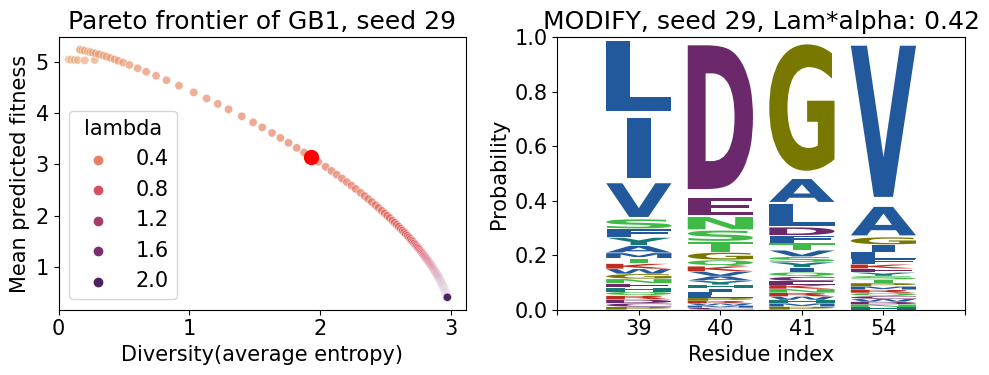

In [7]:
# visualize the library of MODIFY-default
fig, axes = plt.subplots(1,2)

ax = axes[0]
sns.scatterplot(ax=ax, data=df, x='entropy', y='mean fitness', hue='lambda', palette='flare', alpha=0.7)
ax.set(xlim=(0,None), xlabel='Diversity(average entropy)', ylabel='Mean predicted fitness')
l1, = ax.plot([entropy_opt], [mean_fitness_opt], 'ro', ms=10, label='MODIFY-default')
ax.set_title(f'Pareto frontier of {protein}, seed {seed}')

ax=axes[1]
phi = torch.load(f'../results/{protein}/libraries/default_{seed}_{lam}.pt')
q = softmax_mask(phi, modify.mask)
draw_df = pd.DataFrame.from_dict(q)
draw_df.rename(columns=modify.map_i2a, inplace=True)
logo = logomaker.Logo(draw_df,
                    color_scheme='NajafabadiEtAl2017',
                    vpad=.1,
                    width=.8,
                    ax=ax)

logo.ax.set_ylabel('Probability')
logo.ax.set_xlabel('Residue index')
logo.ax.set_xlim([-1, len(positions)])
xticklabels = ['']+positions
logo.ax.set_xticklabels(xticklabels)
ax.set_title(f'MODIFY, seed {seed}, Lam*alpha: {lam}')

plt.tight_layout()
plt.show()

In [8]:
# The probability of top-1 AAs at each residue
print('39L', f"{q[0, modify.map_a2i['L']].item():.2f}")
print('40D', f"{q[1, modify.map_a2i['D']].item():.2f}")
print('41G', f"{q[2, modify.map_a2i['G']].item():.2f}")
print('54V', f"{q[3, modify.map_a2i['V']].item():.2f}")

39L 0.28
40D 0.59
41G 0.52
54V 0.62


## 2. MODIFY default with masked AAs

Here, we demonstrate the usage of masked AAs by masking 39L, 41G just for demonstration purposes. The commands for running optimization is as below.
```
python scripts/run_modify.py \
        --protein GB1 \
        --offset 1 \
        --positions 39,40,41,54 \
        --masked_AAs 39L,41G \
        --fitness_col modify_fitness \
        --parallel \
        --num_proc 60 \
        --seed 29
```

The below codes are for data analyses and visualization.

In [9]:
protein='GB1'
offset = 1
positions=[39,40,41,54]
masked_AAs = ['39L', '41G']
fitness_col='modify_fitness'
seed = 29

In [10]:
modify = MODIFYOptimization(protein, offset, positions, masked_AAs, fitness_col, seed, path='../')

Sequence data for GB1 loaded...
starting sequence: MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
target residues: V39,D40,G41,V54
Mask loaded...
Mask shape: torch.Size([4, 20])
Mask: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]])
Masked AAs: 39L,41G
Fitness data loaded...
[ 1.42466093  0.37217079  0.29993214 ...  1.26230785 -0.4562936
 -0.26499015]


In [11]:
"""
select library with the maximum fitness * diversity
"""

# load libraries as characterized by lambda
df = pd.read_csv(f'../results/GB1/default_pareto_{seed}_{"".join(masked_AAs)}.csv', index_col=0)
df['area'] = df.entropy * df['mean fitness']
df

,lambda,entropy,mean fitness,area
0,0.01,0.059226,4.283521,0.253697
1,0.02,0.066279,4.281197,0.283753
2,0.03,0.076356,4.278259,0.326672
3,0.04,0.092176,4.274013,0.393964
4,0.05,0.126933,4.267182,0.541644
...,...,...,...,...
195,1.96,2.974124,0.202713,0.602894
196,1.97,2.974365,0.200800,0.597252
197,1.98,2.974581,0.199089,0.592205
198,1.99,2.974784,0.197462,0.587407


In [12]:
# find the library with the highest area
entropy_opt, mean_fitness_opt = df.loc[[df.area.argmax()]][['entropy', 'mean fitness']].values.tolist()[0]
lam = df.loc[[df.area.argmax()]]['lambda'].values[0]
lam_default = round(lam,2)
lam_default, entropy_opt, mean_fitness_opt

(0.36, 1.8739506006240845, 2.7732512426076177)

In [13]:
plt.rcParams["figure.figsize"] = (10,4)
plt.rcParams['font.size'] = 15

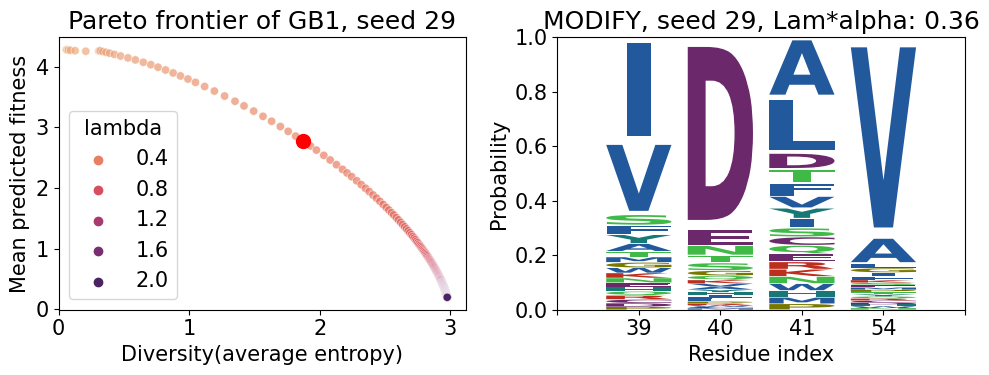

In [14]:
# visualize the library of MODIFY-default
fig, axes = plt.subplots(1,2)

ax = axes[0]
sns.scatterplot(ax=ax, data=df, x='entropy', y='mean fitness', hue='lambda', palette='flare', alpha=0.7)
ax.set(xlim=(0,None), xlabel='Diversity(average entropy)', ylabel='Mean predicted fitness')
l1, = ax.plot([entropy_opt], [mean_fitness_opt], 'ro', ms=10, label='MODIFY-default')
ax.set_title(f'Pareto frontier of {protein}, seed {seed}')

ax=axes[1]
phi = torch.load(f'../results/{protein}/libraries/default_{seed}_{lam}.pt')
q = softmax_mask(phi, modify.mask)
draw_df = pd.DataFrame.from_dict(q)
draw_df.rename(columns=modify.map_i2a, inplace=True)
logo = logomaker.Logo(draw_df,
                    color_scheme='NajafabadiEtAl2017',
                    vpad=.1,
                    width=.8,
                    ax=ax)

logo.ax.set_ylabel('Probability')
logo.ax.set_xlabel('Residue index')
logo.ax.set_xlim([-1, len(positions)])
xticklabels = ['']+positions
logo.ax.set_xticklabels(xticklabels)
ax.set_title(f'MODIFY, seed {seed}, Lam*alpha: {lam}')

plt.tight_layout()
plt.show()

In [15]:
# The probability of top-1 AAs at each residue
print('39L', f"{q[0, modify.map_a2i['L']].item():.2f}")
print('40D', f"{q[1, modify.map_a2i['D']].item():.2f}")
print('41G', f"{q[2, modify.map_a2i['G']].item():.2f}")
print('54V', f"{q[3, modify.map_a2i['V']].item():.2f}")

39L 0.00
40D 0.71
41G 0.00
54V 0.73


## 3. MODIFY informed without masked AAs

Here, we demonstrate the usage of MODIFY informed library design. Note that MODIFY default must first be ran before the implementation of MODIFY informed. The commands for running optimization is as below.
```
python scripts/run_modify.py \
        --protein GB1 \
        --offset 1 \
        --positions 39,40,41,54 \
        --fitness_col modify_fitness \
        --parallel \
        --num_proc 60 \
        --seed 29 \
        --informed \
        --resets 40-0.69
```

The below codes are for data analyses and visualization.

In [16]:
protein='GB1'
offset = 1
positions=[39,40,41,54]
masked_AAs = []
fitness_col='modify_fitness'
seed = 29
lam_name = '0.42-0.69-0.42-0.42' # 0.42 is lam_default in section 1. MODIFY default without masked AAs

In [17]:
modify = MODIFYOptimization(protein, offset, positions, masked_AAs, fitness_col, seed, path='../')

Sequence data for GB1 loaded...
starting sequence: MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
target residues: V39,D40,G41,V54
Mask loaded...
Mask shape: torch.Size([4, 20])
Mask: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]])
No masked AAs
Fitness data loaded...
[ 1.42466093  0.37217079  0.29993214 ...  1.26230785 -0.4562936
 -0.26499015]


In [18]:
"""
load default libraries for visualization
"""

# load libraries as characterized by lambda
df = pd.read_csv(f'../results/GB1/default_pareto_{seed}.csv', index_col=0)
df['area'] = df.entropy * df['mean fitness']
df

,lambda,entropy,mean fitness,area
0,0.01,0.077747,5.046073,0.392316
1,0.02,0.095654,5.043222,0.482405
2,0.03,0.120142,5.039727,0.605481
3,0.04,0.146271,5.035944,0.736610
4,0.05,0.200428,5.030180,1.008191
...,...,...,...,...
195,1.96,2.968106,0.411129,1.220274
196,1.97,2.968390,0.408887,1.213735
197,1.98,2.968679,0.406597,1.207057
198,1.99,2.969004,0.404012,1.199512


In [19]:
# find the library with the highest area
entropy_opt, mean_fitness_opt = df.loc[[df.area.argmax()]][['entropy', 'mean fitness']].values.tolist()[0]
lam = df.loc[[df.area.argmax()]]['lambda'].values[0]
lam_default = round(lam,2)
lam_default, entropy_opt, mean_fitness_opt

(0.42, 1.9245448112487795, 3.1490663135229005)

In [20]:
# find informed library
res_df = pd.read_csv(f'../results/{protein}/informed_pareto_{seed}_{lam_name}.csv', index_col=0)

entropy_final, mean_fitness_final = res_df[['entropy', 'mean fitness']].values.tolist()[0]
entropy_final, mean_fitness_final

(2.148881196975708, 2.6874224167332508)

In [21]:
plt.rcParams["figure.figsize"] = (15,4)
plt.rcParams['font.size'] = 15

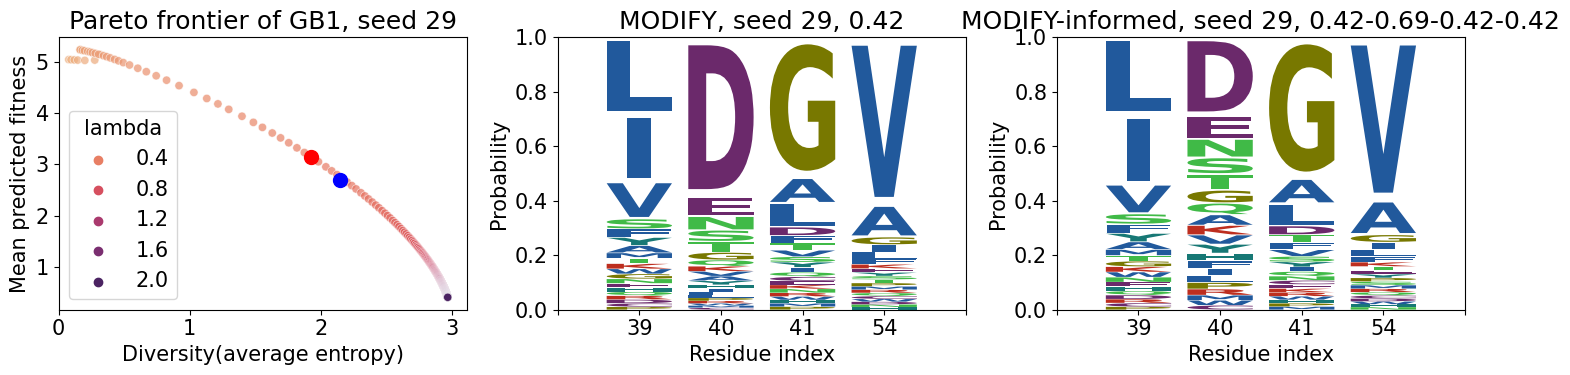

In [22]:
# visualize the library of MODIFY-default and MODIFY-informed
fig, axes = plt.subplots(1,3)

ax = axes[0]
sns.scatterplot(ax=ax, data=df, x='entropy', y='mean fitness', hue='lambda', palette='flare', alpha=0.7)
ax.set(xlim=(0,None), xlabel='Diversity(average entropy)', ylabel='Mean predicted fitness')
l1, = ax.plot([entropy_opt], [mean_fitness_opt], 'ro', ms=10, label='MODIFY-default')
l2, = ax.plot([entropy_final], [mean_fitness_final], 'bo', ms=10, label='MODIFY-informed')
ax.set_title(f'Pareto frontier of {protein}, seed {seed}')

ax=axes[1]
phi = torch.load(f'../results/{protein}/libraries/default_{seed}_{lam_default}.pt')
q = softmax_mask(phi, modify.mask)
draw_df = pd.DataFrame.from_dict(q)
draw_df.rename(columns=modify.map_i2a, inplace=True)
logo = logomaker.Logo(draw_df,
                    color_scheme='NajafabadiEtAl2017',
                    vpad=.1,
                    width=.8,
                    ax=ax)

logo.ax.set_ylabel('Probability')
logo.ax.set_xlabel('Residue index')
logo.ax.set_xlim([-1, len(positions)])
xticklabels = ['']+positions
logo.ax.set_xticklabels(xticklabels)
ax.set_title(f'MODIFY, seed {seed}, {lam}')

ax=axes[2]
phi = torch.load(f'../results/{protein}/libraries/informed_{seed}_{lam_name}.pt')
q = softmax_mask(phi, modify.mask)
draw_df = pd.DataFrame.from_dict(q)
draw_df.rename(columns=modify.map_i2a, inplace=True)
logo = logomaker.Logo(draw_df,
                        color_scheme='NajafabadiEtAl2017',
                        vpad=.1,
                        width=.8,
                        ax=ax)

logo.ax.set_ylabel('Probability')
logo.ax.set_xlabel('Residue index')
logo.ax.set_xlim([-1, len(positions)])
xticklabels = ['']+positions
logo.ax.set_xticklabels(xticklabels)
ax.set_title(f'MODIFY-informed, seed {seed}, {lam_name}')

plt.tight_layout()
plt.show()

In [23]:
# The probability of top-1 AAs at each residue
print('39L', f"{q[0, modify.map_a2i['L']].item():.2f}")
print('40D', f"{q[1, modify.map_a2i['D']].item():.2f}")
print('41G', f"{q[2, modify.map_a2i['G']].item():.2f}")
print('54V', f"{q[3, modify.map_a2i['V']].item():.2f}")

39L 0.29
40D 0.29
41G 0.52
54V 0.60


## 4. Final library construction

In [24]:
N = 500

In [25]:
protein='GB1'
offset = 1
positions=[39,40,41,54]
masked_AAs = []
fitness_col='modify_fitness'
seed = 29
lam_name = '0.42-0.69-0.42-0.42' # 0.42 is lam_default in section 1. MODIFY default without masked AAs

In [26]:
modify = MODIFYOptimization(protein, offset, positions, masked_AAs, fitness_col, seed, path='../')

Sequence data for GB1 loaded...
starting sequence: MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
target residues: V39,D40,G41,V54
Mask loaded...
Mask shape: torch.Size([4, 20])
Mask: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]])
No masked AAs
Fitness data loaded...
[ 1.42466093  0.37217079  0.29993214 ...  1.26230785 -0.4562936
 -0.26499015]


In [27]:
# load data for structure-based filtering

df = pd.read_csv('../data/GB1/GB1_zero.csv', index_col=0)
df1 = pd.read_csv('../data/GB1/raw/GB1_structure.csv', index_col=0)
df = df.merge(df1, on='mutant', how='left')
df

,mutant,name_x,modify_fitness,name_y,esmfold,FoldX
0,VA39A;DA40A;GA41A;VA54A,AAAA,1.424661,AAAA,84.333393,10.30980
1,VA39A;DA40A;GA41A;VA54C,AAAC,0.372171,AAAC,85.365536,9.95875
2,VA39A;DA40A;GA41A;VA54D,AAAD,0.299932,AAAD,87.307857,13.62200
3,VA39A;DA40A;GA41A;VA54E,AAAE,0.474203,AAAE,87.835714,11.91480
4,VA39A;DA40A;GA41A;VA54F,AAAF,0.653248,AAAF,83.268571,15.18530
...,...,...,...,...,...,...
159995,VA39Y;DA40Y;GA41Y;VA54S,YYYS,-0.323629,YYYS,84.558571,62.52500
159996,VA39Y;DA40Y;GA41Y;VA54T,YYYT,-0.255611,YYYT,84.521071,71.58080
159997,VA39Y;DA40Y;GA41Y;VA54V,YYYV,1.262308,YYYV,84.197143,68.21390
159998,VA39Y;DA40Y;GA41Y;VA54W,YYYW,-0.456294,YYYW,82.789643,109.66700


In [28]:
print(len(df), df.esmfold.median(), df.FoldX.median())

160000 82.03732142857143 24.6212


In [33]:
def sample(mask, map_i2a, seed, protein, num_position, y, sample_seed=2023):

    phi = torch.load(f'../results/{protein}/libraries/informed_{seed}_{lam_name}.pt')
    q = softmax_mask(phi, mask)

    M = 4000
    torch.random.manual_seed(sample_seed) 
    samples = torch.vstack([torch.multinomial(q[i], M, replacement=True) for i in range(num_position)]) 
    indices = (samples * 20**(num_position-1-torch.arange(num_position).view(num_position,1).repeat(1,M))).sum(dim=0).tolist()
    scores = [y[idx] for idx in indices]

    xs = []
    for i in range(M):
        x = ','.join([str(x) for x in samples[:,i].tolist()])
        xs.append(x)

    def x2mut(x):
        muts = [map_i2a[int(a)] for a in x.split(',')]
        return f'VA39{muts[0]};DA40{muts[1]};GA41{muts[2]};VA54{muts[3]}'

    sample_df = pd.DataFrame({'x':xs, 'idx': indices, 'prob_score':scores})
    sample_df['mutant'] = sample_df.x.apply(lambda x: x2mut(x))

    sample_df.drop_duplicates('mutant', keep='first', inplace=True)
    sample_df.reset_index(inplace=True)

    def x2name(x):
        muts = [map_i2a[int(a)] for a in x.split(',')]
        name = ''.join(muts)
        return name

    sample_df['name'] = sample_df.x.apply(lambda x: x2name(x))
    sample_df = sample_df.merge(df[['mutant', 'esmfold', 'FoldX']], on='mutant', how='left')
    
    return sample_df

In [34]:
# MODIFY-informed library of size 500
t_df = sample(modify.mask, modify.map_i2a, seed, protein, modify.num_position, modify.fitnesses)
t_df = t_df[(t_df.esmfold>=85)|(t_df.FoldX<=25)].head(N)
t_df

,index,x,idx,prob_score,mutant,name,esmfold,FoldX
0,0,"9,15,5,17",78117,4.079466,VA39L;DA40S;GA41G;VA54V,LSGV,89.501607,-0.738674
2,2,"7,0,1,0",56020,1.488532,VA39I;DA40A;GA41C;VA54A,IACA,87.490357,12.478400
3,3,"7,13,5,6",61306,1.976608,VA39I;DA40Q;GA41G;VA54H,IQGH,85.400714,5.987670
4,4,"9,7,5,17",74917,3.506840,VA39L;DA40I;GA41G;VA54V,LIGV,91.130536,0.692297
5,5,"7,9,12,17",59857,1.734481,VA39I;DA40L;GA41P;VA54V,ILPV,81.234821,6.804700
...,...,...,...,...,...,...,...,...
568,715,"7,3,19,3",57583,1.210047,VA39I;DA40E;GA41Y;VA54E,IEYE,87.315536,36.537900
569,716,"1,11,2,17",12457,1.684045,VA39C;DA40N;GA41D;VA54V,CNDV,83.872143,15.222600
570,717,"17,19,9,17",143797,2.537635,VA39V;DA40Y;GA41L;VA54V,VYLV,83.793393,22.118400
571,719,"13,9,5,17",107717,2.186129,VA39Q;DA40L;GA41G;VA54V,QLGV,84.438929,2.091300


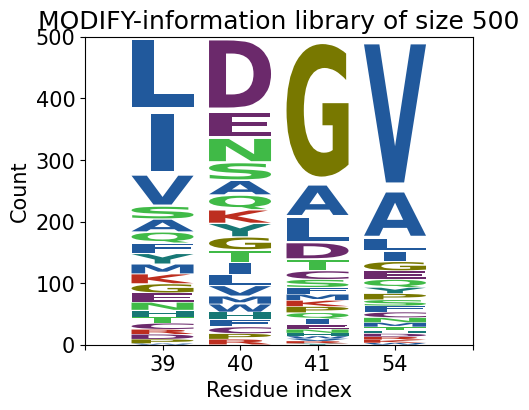

In [35]:
# Visualize the distribution of AAs of this size 500 library

plt.rcParams["figure.figsize"] = (5,4)
fig, ax = plt.subplots(1, 1)

res = np.zeros((4,20))
for row in t_df.iterrows():
    for i,j in enumerate(row[1]['name']):
        res[i, modify.map_a2i[j]] += 1

draw_df = pd.DataFrame.from_dict(res)
draw_df.rename(columns=modify.map_i2a, inplace=True)
logo = logomaker.Logo(draw_df,
                        color_scheme='NajafabadiEtAl2017',
                        vpad=.1,
                        width=.8,
                        ax=ax)
logo.ax.set_ylabel('Count')
logo.ax.set_xlabel('Residue index')
logo.ax.set_xlim([-1, len(positions)])
xticklabels = ['']+positions
logo.ax.set_xticklabels(xticklabels)
ax.set_title(f'MODIFY-information library of size {N}')

plt.show()